In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from simulate import TaxiSimulator
from constants import (
    TIME_BLOCK_BOUNDARY,
    TAXI_INIT, 
    RIDER_ARRIVAL,
    RIDE_START, 
    RIDER_LOST,
    RIDE_COMPLETION, 
    RELOCATION_START, 
    RELOCATION_COMPLETION
)
from relocation_policies import (
    relocation_policy_blind_sampling,
    relocation_policy_jlcr_eta,
    relocation_policy_shortest_wait,
)

np.set_printoptions(suppress=True)

In [2]:
# Simulation parameters
Delta = 20 # in minutes
max_time = 72  # Simulate 72 hours
N = 8000
start_time = pd.Timestamp('2025-01-02 00:00:00')

Use actual parameters

In [3]:
with np.load('../nyc_trip/trip_counts.npz') as data:
    trip_counts = data['trip_counts']
    num_dates = data['num_dates']

with np.load('../nyc_trip/mu_cp.npz') as data:
    mu_ = data['mu']
    
# mask trip_counts by 1 where 0
trip_counts[trip_counts == 0] = 1

# compute arrival rate
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)

# normalize trip_counts
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)

# with np.load('../nyc_trip/Qs_2.npz') as data:
#     Q_2 = data['Qs']

with np.load('../nyc_trip/Qs_4.npz') as data:
    Q_4 = data['Qs']

with np.load('../nyc_trip/Qs_8.npz') as data:
    Q_8 = data['Qs']

T, R, _ = P.shape

Q_base = np.array([np.identity(R) for _ in range(T)])

In [ ]:
eta = 0.5

sim = TaxiSimulator(
    T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q_4,
    relocation_policy=relocation_policy_jlcr_eta, relocation_kwargs={'eta': eta}
)
sim.run(max_time=max_time)
df_log = pd.DataFrame(sim.logger)

# save df_log as any efficient format
df_log.to_parquet(f'sim_result/log_jlcr_{eta}.parquet')

In [ ]:
sim = TaxiSimulator(
    T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q_4,
    relocation_policy=relocation_policy_shortest_wait
)
sim.run(max_time=max_time)
df_log = pd.DataFrame(sim.logger)

# save df_log as any efficient format
df_log.to_parquet(f'sim_result/log_shortestwait.parquet')

In [7]:
sim2 = TaxiSimulator(
    T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q_4,
    relocation_policy=relocation_policy_blind_sampling
)
sim2.run(max_time=max_time)
df_log2 = pd.DataFrame(sim2.logger)

# save df_log as any efficient format
df_log2.to_parquet(f'sim_result/log_Q4.parquet')

In [8]:
sim3 = TaxiSimulator(
    T=T, R=R, N=N, lambda_=lambda_, mu_=mu_, P=P, Q=Q_base,
    relocation_policy=relocation_policy_blind_sampling
)
sim3.run(max_time=max_time)
df_log3 = pd.DataFrame(sim3.logger)

# save df_log as any efficient format
df_log3.to_parquet(f'sim_result/log_no_relocation.parquet')

In [12]:
start_time = pd.Timestamp('2025-01-02 00:00:00')

df_log = df_log[df_log.event_type != TIME_BLOCK_BOUNDARY].reset_index(drop=True)
df_log['datetime'] = start_time + pd.to_timedelta(df_log['time'], unit='h')

df_log2 = df_log2[df_log2.event_type != TIME_BLOCK_BOUNDARY].reset_index(drop=True)
df_log2['datetime'] = start_time + pd.to_timedelta(df_log2['time'], unit='h')

df_log3 = df_log3[df_log3.event_type != TIME_BLOCK_BOUNDARY].reset_index(drop=True)
df_log3['datetime'] = start_time + pd.to_timedelta(df_log3['time'], unit='h')

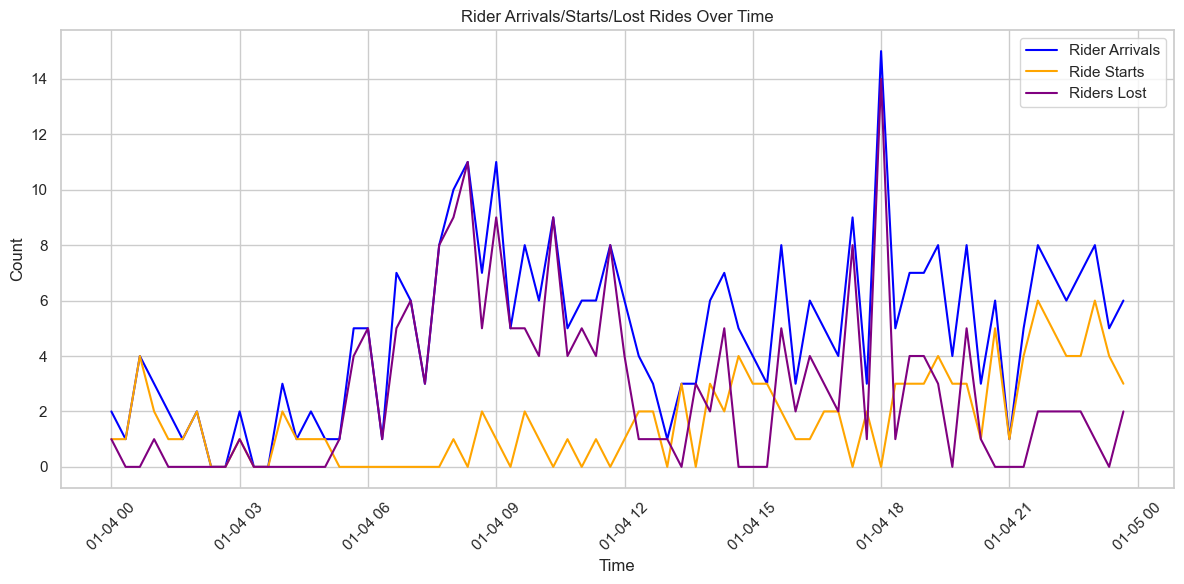

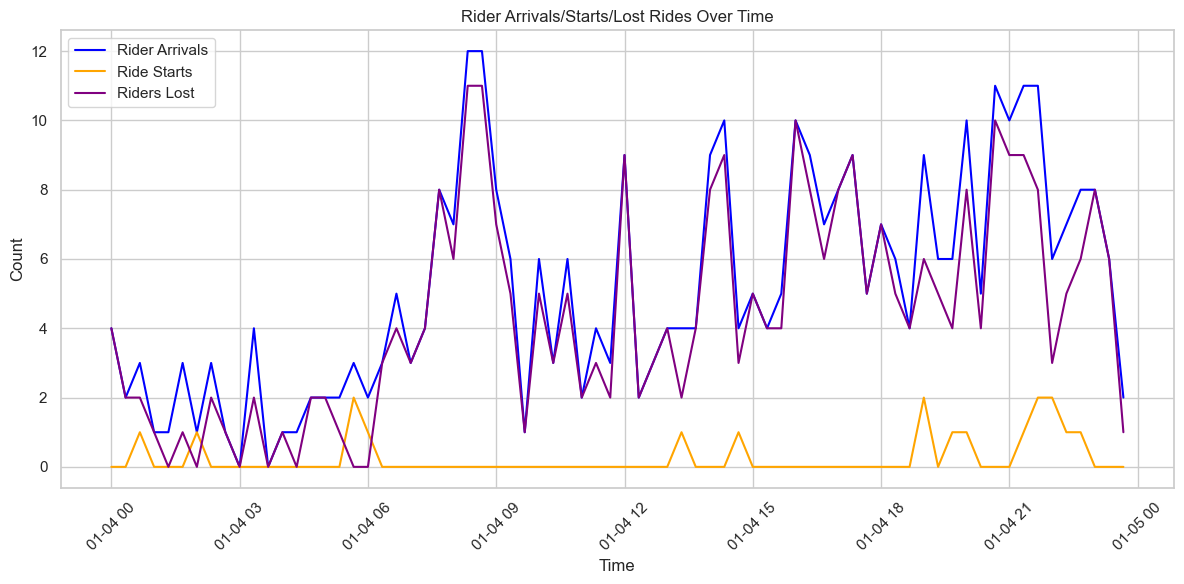

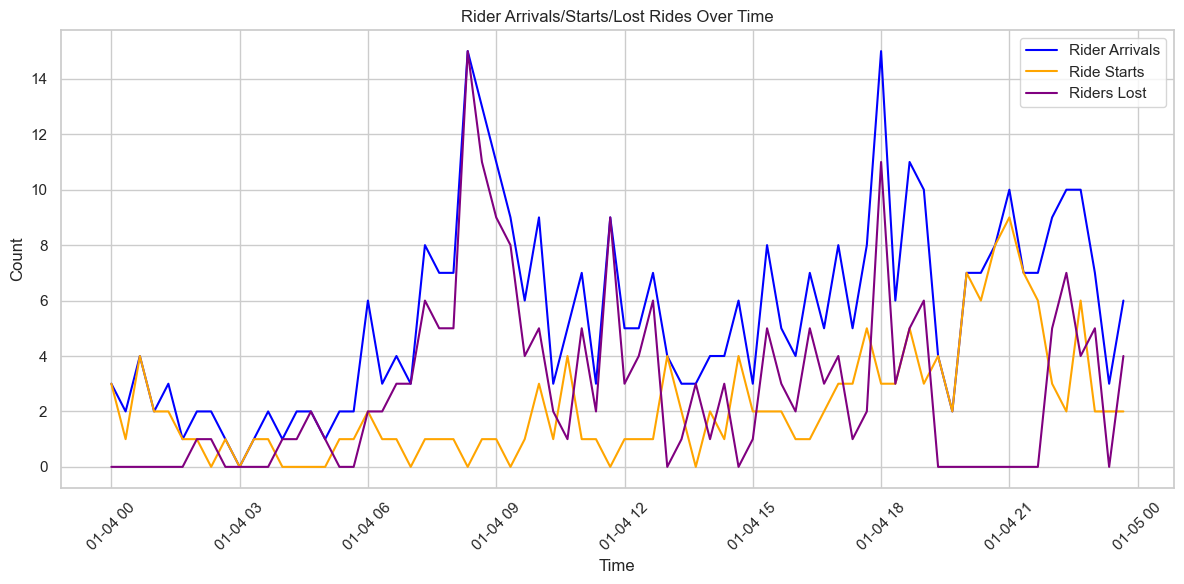

In [25]:
region_id = 46

plot_arrival_versus_ridestarts(df_log=df_log, region_id=region_id, bin_minutes=20)
plot_arrival_versus_ridestarts(df_log=df_log2, region_id=region_id, bin_minutes=20)
plot_arrival_versus_ridestarts(df_log=df_log3, region_id=region_id, bin_minutes=20)